In [1]:
import sys 
sys.path.append("../..")

import asyncio
import numpy as np
import torch

import pykep as pk
import paseos
from paseos import ActorBuilder, SpacecraftActor
from simple_neural_network import SimpleNeuralNetwork

09:53:57|PASEOS-DEBUG| Setting LogLevel to DEBUG
09:53:57|PASEOS-DEBUG| Loaded module.


#### A Node class contains the PASEOS instance and a neural network

In [2]:
class Node:
    def __init__(self, node_id,  pos_and_vel, paseos_cfg):
        
        # Create PASEOS instance to node
        earth = pk.planet.jpl_lp("earth")
        self.node_id = node_id
        sat = ActorBuilder.get_actor_scaffold(f"sat{node_id}", SpacecraftActor, pk.epoch(0))
        ActorBuilder.set_orbit(sat, pos_and_vel[0], pos_and_vel[1], pk.epoch(0), earth)
        ActorBuilder.set_power_devices(sat, 500, 10000, 1)
        ActorBuilder.add_comm_device(sat, device_name="link", bandwidth_in_kbps=100)
        self.paseos = paseos.init_sim(sat, paseos_cfg)
        
        # Create a simple neural network
        self.model = SimpleNeuralNetwork(node_id)
        self.model.set_optimizer(torch.optim.SGD(self.model.parameters(), lr=0.1))
        self.model.set_loss_fn(torch.nn.BCELoss())
        
        tx_bits = self.model_size()
        self.tx_duration = tx_bits / (1000*self.paseos.local_actor.communication_devices['link'].bandwidth_in_kbps)
        self.paseos.register_activity("Train", activity_function=self.train, power_consumption_in_watt=0)
        
    
    def model_size(self):
        # Return model parameters as a list of NumPy ndarrays
        bytestream = b""  # Empty byte represenation
        for _, val in self.model.state_dict().items():  # go over each layer
            bytestream += val.cpu().numpy().tobytes()  # convert layer to bytes and concatenate
        return len(bytestream)*8
    
    def advance_time(self, dt, current_power_consumption_in_W=0):
        self.paseos.advance_time(dt,current_power_consumption_in_W)
    
    def local_time(self):
        return self.paseos.local_actor.local_time.mjd2000 * pk.DAY2SEC
    
    def add_node(self, node):
        self.paseos.add_known_actor(node.paseos.local_actor)
    
    def tx_is_feasible(self, target_node):
        target_actor = target_node.paseos.local_actor
        local_actor = self.paseos.local_actor
        tx_end = pk.epoch(self.local_time() + self.tx_duration)
        
        los_start = local_actor.is_in_line_of_sight(target_actor, pk.epoch(self.local_time()))
        los_end = local_actor.is_in_line_of_sight(target_actor, tx_end)
        return (los_start and los_end)
    
    def merge_model(self, rx_model):
        local_sd = self.model.state_dict()
        rx_sd = rx_model.state_dict()
        for key in local_sd:
            local_sd[key] = 0.5 * local_sd[key] + 0.5*rx_sd[key]
        self.model.load_state_dict(local_sd)
    
    async def wait_for_activity(self):
        while self.paseos._is_running_activity is True:
            await asyncio.sleep(0.1)
    
    async def train(self, args):
        self.model.train()
        acc = self.model.eval()
        args.append(acc)
        

#### Create two nodes orbiting Earth in different directions

In [3]:
# Speed up simulation
paseos_cfg = paseos.load_default_cfg()  # loading paseos cfg to modify defaults
paseos_cfg.sim.time_multiplier = 100
        
# Create nodes
pos1 = [0, 10000000, 0]
vel1 = [0, 0, 8000.0]
node1 = Node(1, [pos1, vel1], paseos_cfg)

pos2 = [0, -10000000, 0]
vel2 = [0, 0, 8000.0]
node2 = Node(2, [pos2, vel2], paseos_cfg)

# make the nodes aware of each other
node1.add_node(node2)
node2.add_node(node1)

09:54:02|PASEOS-DEBUG| loading default cfg from path: /Users/johanostman/Dropbox/Machine Learning/Decentralized AI/Code/PASEOS/examples/Learning_example/../../paseos/utils/../resources/default_cfg.toml
09:54:02|PASEOS-DEBUG| Added orbit to actor sat1
09:54:02|PASEOS-DEBUG| Added power device. MaxBattery=10000Ws, CurrBattery=500Ws, ChargingRate=1W to actor sat1
09:54:02|PASEOS-DEBUG| Added comm device with bandwith=100 kbps to actor sat1.
09:54:02|PASEOS-DEBUG| Initializing simulation.
09:54:02|PASEOS-DEBUG| Registered activity DotMap(activity_function=<bound method Node.train of <__main__.Node object at 0x104bbad00>>, power_consumption_in_watt=0, on_termination_function=None, constraint_function=None)
09:54:02|PASEOS-DEBUG| Added orbit to actor sat2
09:54:02|PASEOS-DEBUG| Added power device. MaxBattery=10000Ws, CurrBattery=500Ws, ChargingRate=1W to actor sat2
09:54:02|PASEOS-DEBUG| Added comm device with bandwith=100 kbps to actor sat2.
09:54:02|PASEOS-DEBUG| Initializing simulation.
0

#### Plot the nodes' datasets

Text(0.5, 1.0, 'Test data')

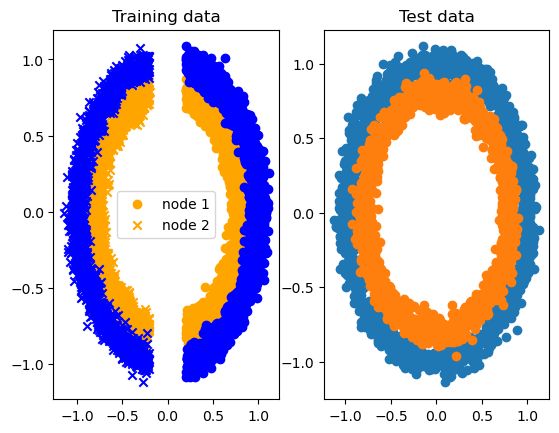

In [4]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,2)

X1 = np.asarray(node1.model.train_dataloader.dataset.X)
y1 = np.asarray(node1.model.train_dataloader.dataset.y)
axes[0].scatter(X1[y1==1,0], X1[y1==1,1], label = "node 1", color="orange")
axes[0].scatter(X1[y1==0,0], X1[y1==0,1], color="blue")

X2 = np.asarray(node2.model.train_dataloader.dataset.X)
y2 = np.asarray(node2.model.train_dataloader.dataset.y)
axes[0].scatter(X2[y2==1,0], X2[y2==1,1],marker='x', label = "node 2", color="orange")
axes[0].scatter(X2[y2==0,0], X2[y2==0,1],marker='x', color="blue")
axes[0].set_title("Training data")
axes[0].legend()

X = np.asarray(node1.model.test_dataloader.dataset.X)
y = np.asarray(node1.model.test_dataloader.dataset.y)
axes[1].scatter(X[y==0,0], X[y==0,1])
axes[1].scatter(X[y==1,0], X[y==1,1])
axes[1].set_title("Test data")

#### Train PASEOS

<IPython.core.display.Javascript object>


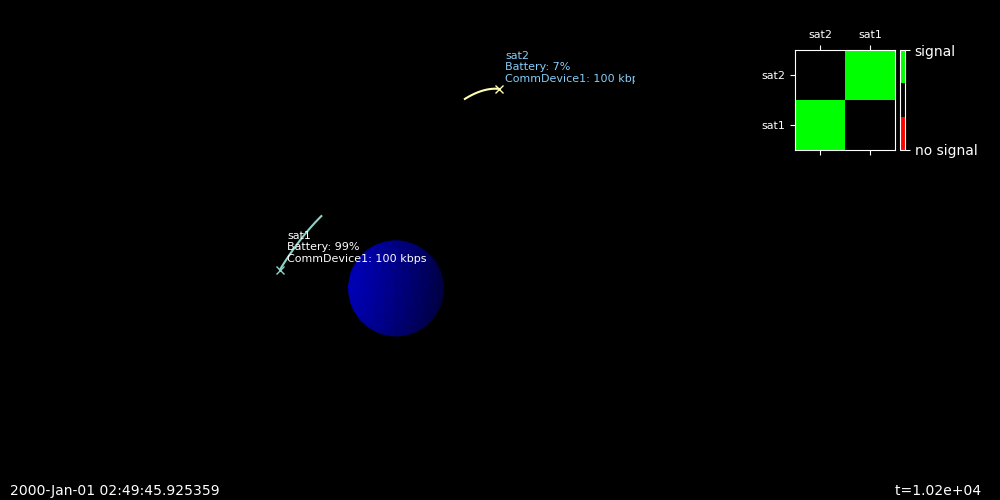

In [5]:
%matplotlib notebook
paseos.set_log_level("INFO")
plotter = paseos.plot(node1.paseos, paseos.PlotType.SpacePlot)

acc1 = []
acc2 = []
t_share = []
dt = 100

for i in range(100):
    if node1.tx_is_feasible(node2):
        # Share and merge models
        node1.merge_model(node2.model)
        node2.merge_model(node1.model)
        
        # Update time due to transmission
        node1.paseos.advance_time(node1.tx_duration, 0)
        t_share.append(i)
        
    # Train models
    await node1.paseos.perform_activity("Train", acc1)
    await node2.paseos.perform_activity("Train", acc2)
    
    node1.paseos.advance_time(dt, 0)
    plotter.update(node1.paseos)


#### Illustrate the test accuracy

<IPython.core.display.Javascript object>


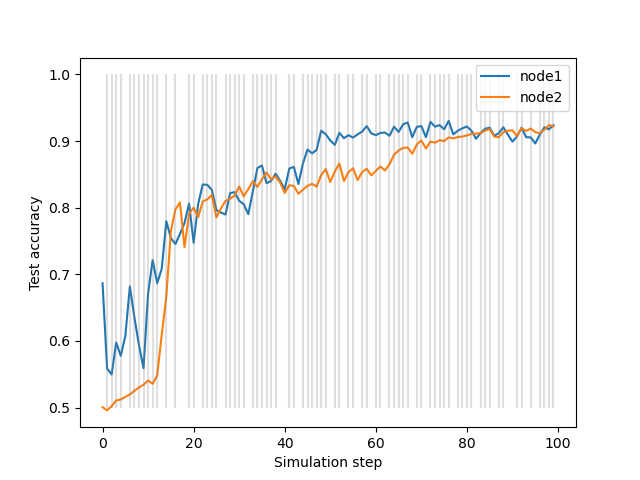

In [6]:
fig, axes = plt.subplots(1,1)
axes.plot(range(len(acc1)), acc1, label="node1")
axes.plot(range(len(acc2)), acc2, label="node2")
# mark rounds where models are shared
axes.vlines(t_share, 0.5, 1, color="grey", alpha=0.25)
axes.set_ylabel("Test accuracy")
axes.set_xlabel("Simulation step")
axes.legend()